In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist, obs_coronagraphy
from pynrc.obs_nircam import plot_contrasts, planet_mags, plot_planet_patches

from pynrc.speckle_noise import offset_bar
pynrc.setup_logging('WARNING', verbose=False)

from astropy.io import (fits, ascii)

# Observation Definitions

Functions to create and optimize a series of observation objects stored as a dictionary.

In [3]:
def make_key(filter, pupil=None, mask=None):
    """Create identification key (string) based on filter, pupil, and mask"""
    mask_key = 'none' if mask is None else mask
    pupil_key = 'none' if pupil is None else pupil
    key = '{}_{}_{}'.format(filter,mask_key,pupil_key)
    return key

In [4]:
def obs_wfe(wfe_drift, filt_list, sp_sci, dist, sp_ref=None, args_disk=None, 
            subsize=None, wind_mode=None, fov_pix=None, verbose=False):
    """
    For a given WFE drift and series of filters, create a list of 
    NIRCam observations. This function will calculate PSFs out to 320 pixels. 
    For the case of SW+MASK335R, we also assume that the subarray size matches 
    that of a simultaneous LW observation (320x320).
    """
    
    if sp_ref is None: sp_ref = sp_sci

    obs_dict = {}
    for filt, mask, pupil in filt_list:
        # Create identification key
        key = make_key(filt, mask=mask, pupil=pupil)
        if verbose: print(key)

        # Disk Model
        if args_disk is None:
            hdu_disk = None
        else:
            hdu_disk = model_to_hdulist(args_disk, sp_sci, filt, pupil=pupil, mask=mask)

        if wind_mode is None:
            wind_mode = 'WINDOW'
            
        # Define the subarray readout size
        if subsize is None:
            if mask is None: # Direct Imaging
                subsize = 400
            elif ('210R' in mask) or ('SWB' in mask): # SW Coronagraphy
                subsize = 640
            else: # LW Coronagraphy
                subsize = 320
        if 'FULL' in wind_mode:
            subsize=2048
                
        # Define PSF pixel size
        fov_pix_orig = fov_pix
        fov_pix = subsize if fov_pix is None else fov_pix
        # Make sure fov_pix is odd for direct imaging
        if (mask is None) and (np.mod(fov_pix,2)==0):
            fov_pix += 1

        # Other coronagraph vs direct imaging settings
        module, oversample = ('B', 4) if mask is None else ('A', 2)
        
        # Initialize and store the observation
        # A reference obseration is stored inside each parent obs_coronagraphy class.
        obs_dict[key] = pynrc.obs_hci(sp_sci, sp_ref, dist, filter=filt, mask=mask, pupil=pupil, 
                                      wfe_ref_drift=wfe_drift, fov_pix=fov_pix, oversample=oversample, 
                                      wind_mode=wind_mode, xpix=subsize, ypix=subsize,
                                      disk_hdu=hdu_disk, verbose=verbose)
        fov_pix = fov_pix_orig
        
    return obs_dict

# Sources and Bandpasses

Define Sources and their Reference Counterparts

In [5]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [6]:
# Science         source,  dist,  age, sptype, Teff, [Fe/H], log_g, mag, band
args_sources = [('Vega',    7.7,  450,  'A0V', 9602, -0.50, 4.10, 0.13, bp_k)]

# References     source, sptype, Teff, [Fe/H], log_g, mag, band
ref_sources = [('Deneb',  'A2I', 8525, -0.25, 2.00, 0.88, bp_k)]

In [7]:
# List of filters
args_filter = [('F356W', 'MASK430R', 'CIRCLYOT'),
               ('F444W', 'MASK430R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

In [8]:
# Fit spectrum to SED photometry

i=0
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sources[i]
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]

# Source spectrum
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
sp_sci = pynrc.stellar_spectrum(spt_sci, mag_sci, 'vegamag', bp_sci, **kwargs)
sp_sci.name = name_sci

kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
sp_ref = pynrc.stellar_spectrum(spt_ref, mag_ref, 'vegamag', bp_ref, **kwargs)
sp_ref.name = name_ref

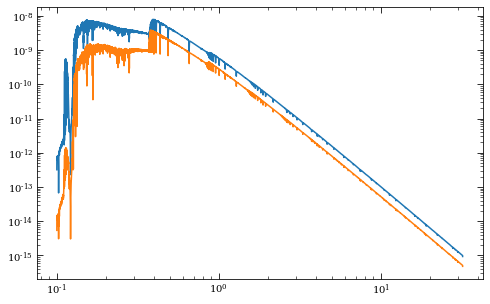

In [9]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.loglog(sp_sci.wave/1e4, sp_sci.flux)
ax.loglog(sp_ref.wave/1e4, sp_ref.flux)

In [10]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, 
                   wind_mode='FULL', fov_pix=1024, verbose=True)

F356W_MASK430R_CIRCLYOT
Generating background PSF coefficients...
Generating oversampled PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.
F444W_MASK430R_CIRCLYOT
Generating background PSF coefficients...
Generating oversampled PSFs...
Updating NIRCam reference coefficients...
Creating NIRCam reference class...
Finished.


In [11]:
obs1 = obs_dict[filt_keys[0]] # F356W
obs2 = obs_dict[filt_keys[1]] # F444W

In [12]:
# Update exposure times (per roll)
obs1.update_detectors(read_mode='RAPID', ngroup=9, nint=5)
obs1.nrc_ref.update_detectors(read_mode='RAPID', ngroup=9, nint=5)

obs2.update_detectors(read_mode='BRIGHT1', ngroup=9, nint=5)
obs2.nrc_ref.update_detectors(read_mode='BRIGHT1', ngroup=9, nint=5)

In [29]:
# Max Saturation values and locations (80% at 2 groups)
for key in filt_keys:
    print(key)
    obs = obs_dict[key]
    
    ng = 2
    im_sat1 = obs.saturation_levels(ngroup=ng, do_ref=False)
    im_sat2 = obs.saturation_levels(ngroup=ng, do_ref=True)
    rho = nrc_utils.dist_image(im_sat1)  # Pixel distances
    dmax1 = np.max(rho[im_sat1==im_sat1.max()]) * obs.pix_scale
    dmax2 = np.max(rho[im_sat2==im_sat2.max()]) * obs.pix_scale

    print('Max sci saturation of {:.1f} well at {:.1f} arcsec'.format(im_sat1.max(), dmax1))
    print('Max ref saturation of {:.1f} well at {:.1f} arcsec'.format(im_sat2.max(), dmax2))

    
    # How many saturated values can we easily fix?
    for sat_level in [im_sat1, im_sat2]:
        sat_mask = sat_level > 0.8
        nsat0 = np.size(rho[sat_mask])
        sat_level[sat_mask] = np.nan
        sat_level = nrc_utils.fix_nans_with_med(sat_level, niter_max=2)

        # Set any NaNs to 1.0
        nan_mask = np.isnan(sat_level)
        sat_level[nan_mask] = 1
        sat_mask = sat_level > 0.8
    
        # Get final info about saturation levels
        nsat = np.size(rho[sat_mask])
        rval = rho[sat_mask].max()*obs.pix_scale if nsat>0 else 0
        print('nsat = ({}, {}); rmax = {:.2f} arcsec'.format(nsat0, nsat, rval))
        
    print('')


F356W_MASK430R_CIRCLYOT
Max sci saturation of 11.3 well at 0.4 arcsec
Max ref saturation of 5.8 well at 0.4 arcsec
nsat = (1203, 121); rmax = 1.28 arcsec
nsat = (584, 3); rmax = 1.14 arcsec

F444W_MASK430R_CIRCLYOT
Max sci saturation of 6.8 well at 0.5 arcsec
Max ref saturation of 3.4 well at 0.5 arcsec
nsat = (1129, 43); rmax = 1.48 arcsec
nsat = (453, 0); rmax = 0.00 arcsec



In [124]:
obs = obs1

In [125]:
# Cycle through a few WFE drift values
wfe_list = [0,2,5,10]

# PA values for each roll
PA1, PA2 = (200, 210)

# PA values for each roll
roll_angle = np.abs(PA2-PA1)

# A dictionary of HDULists
hdul_dict = {}
curves = []
for wfe_drift in wfe_list:
    print(wfe_drift)
    # Upate WFE reference drift value
    obs.wfe_ref_drift = wfe_drift
            
    # Set the final output image to be oversampled
    hdulist = obs.gen_roll_image(PA1=PA1, PA2=PA2, oversample=1)

    # Generate contrast curves
    rr, contrast, sen_mag = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, hdu_diff=hdulist)

    # Mask r<1.5"
    data = hdulist[0].data
    rho = nrc_utils.dist_image(data, pixscale=hdulist[0].header['PIXELSCL'])
    data[rho<1.5] = 0
    hdul_dict[wfe_drift] = hdulist
    
    # Only keep rr>1.5"
    ind = rr>1.5
    result = (rr[ind], contrast[ind], sen_mag[ind])
    curves.append(result)

0
2
5
10


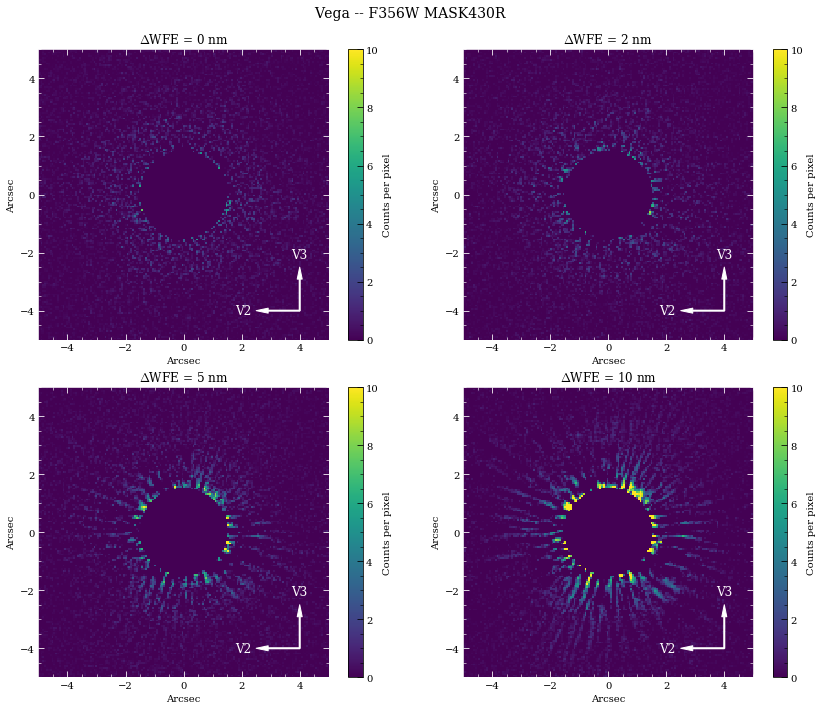

In [53]:
from pynrc.obs_nircam import plot_hdulist
from matplotlib.patches import Circle

fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()
xylim = 5

for j, wfe_drift in enumerate(wfe_list):
    ax = axes[j]
    hdul = hdul_dict[wfe_drift]
    
    xyr = [-xylim, xylim]
    plot_hdulist(hdul, xr=xyr, yr=xyr, ax=ax, vmin=0, vmax=10)

    ax.set_title('$\Delta$WFE = {:.0f} nm'.format(wfe_drift))
    
    nrc_utils.plotAxes(ax, width=1, headwidth=5, alength=0.15)


fig.suptitle('{} -- {} {}'.format(name_sci, obs.filter, obs.mask), fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.92)

fig_name = '{}_{}_{}_images.pdf'.format(name_sci, obs.filter, obs.mask)
fig.savefig('Exoplanets/'+fig_name)

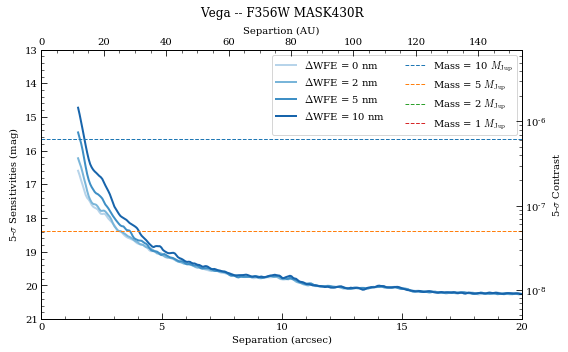

In [128]:
from pynrc.obs_nircam import plot_contrasts, plot_planet_patches

fig, ax = plt.subplots(figsize=(8,5))
xr=[0,20]
yr=[21,13]

# Plot contrast curves and set x/y limits
ax, ax2, ax3 = plot_contrasts(curves, nsig, wfe_list, obs=obs, 
                              xr=xr, yr=yr, ax=ax, return_axes=True)

# Plot Spiegel & Burrows (2012) exoplanet fluxes (Hot Start)
plot_planet_patches(ax, obs, age=age, entropy=13, av_vals=None)
#ax.set_title(ax.get_title(), y=1.1)

ax.legend(ncol=2)

ax.set_title('{} -- {} {}'.format(name_sci, obs.filter, obs.mask), y=1.1)

fig.tight_layout()

fig_name = '{}_{}_{}_contrast.pdf'.format(name_sci, obs.filter, obs.mask)
fig.savefig('Exoplanets/'+fig_name)
#fig.subplots_adjust(top=0.6)

In [126]:
from astropy.table import Table


# Save curves data
data = []
names =[]

rr = curves[0][0]
data.append(rr)
names.append('Arcsec')

for j, vals in enumerate(curves):
    rr, contrast, sen = vals
    
    data.append(contrast)
    data.append(sen)
    
    wfe = wfe_list[j]
    names.append('Contr_{:.0f}nm'.format(wfe))
    names.append('Sen_{:.0f}nm'.format(wfe))
    
# Modify number formats
tbl = Table(data, names=names)
tbl[names[0]].format = '.4f'
for name in names:
    fmt = tbl[name].format
    if 'Cont' in name:
        fmt = '.3E'
    elif 'Sen' in name:
        fmt ='.4f'
        
    tbl[name].format = fmt

In [127]:
# Save data
fname = '{}_{}_{}_curves'.format(name_sci, obs.filter, obs.mask)
ascii.write(tbl, 'Exoplanets/'+fname+'.dat')  
ascii.write(tbl, 'Exoplanets/'+fname+'.csv', format='csv')  

In [55]:
obs = obs2

In [57]:
# Cycle through a few WFE drift values
wfe_list = [0,2,5,10]

# PA values for each roll
PA1, PA2 = (200, 210)

# PA values for each roll
roll_angle = np.abs(PA2-PA1)

# A dictionary of HDULists
hdul_dict = {}
curves = []
for wfe_drift in wfe_list:
    print(wfe_drift)
    # Upate WFE reference drift value
    obs.wfe_ref_drift = wfe_drift
            
    # Set the final output image to be oversampled
    hdulist = obs.gen_roll_image(PA1=PA1, PA2=PA2, oversample=1)

    # Generate contrast curves
    rr, contrast, sen_mag = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig, hdu_diff=hdulist)

    # Mask r<1.5"
    data = hdulist[0].data
    rho = nrc_utils.dist_image(data, pixscale=hdulist[0].header['PIXELSCL'])
    data[rho<1.5] = 0
    hdul_dict[wfe_drift] = hdulist
    
    # Only keep rr>1.5"
    ind = rr>1.5
    result = (rr[ind], contrast[ind], sen_mag[ind])
    curves.append(result)

0
2
5
10


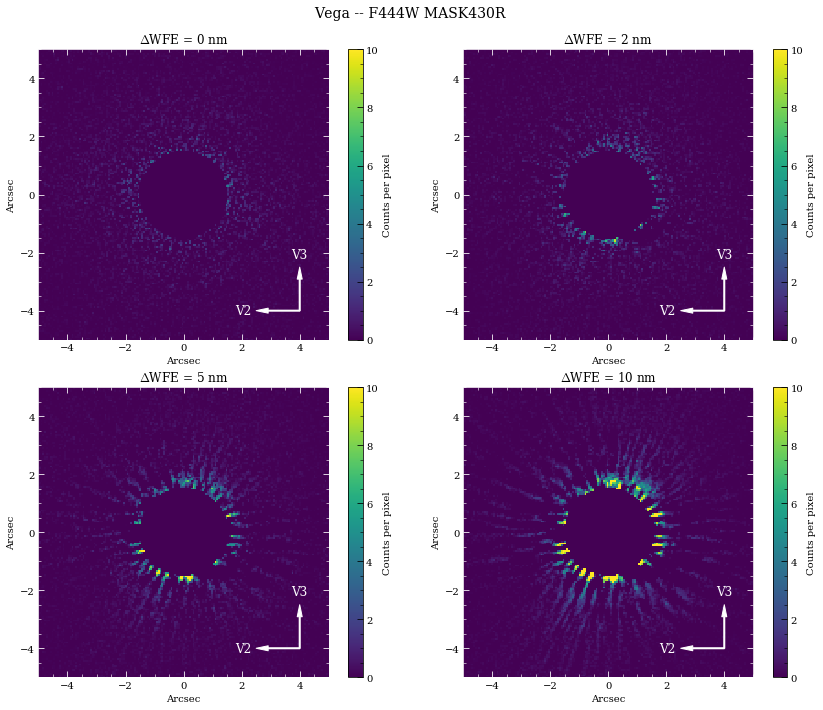

In [58]:
from pynrc.obs_nircam import plot_hdulist
from matplotlib.patches import Circle

fig, axes = plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()
xylim = 5

for j, wfe_drift in enumerate(wfe_list):
    ax = axes[j]
    hdul = hdul_dict[wfe_drift]
    
    xyr = [-xylim, xylim]
    plot_hdulist(hdul, xr=xyr, yr=xyr, ax=ax, vmin=0, vmax=10)

    ax.set_title('$\Delta$WFE = {:.0f} nm'.format(wfe_drift))
    
    nrc_utils.plotAxes(ax, width=1, headwidth=5, alength=0.15)


fig.suptitle('{} -- {} {}'.format(name_sci, obs.filter, obs.mask), fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.92)

fig_name = '{}_{}_{}_images.pdf'.format(name_sci, obs.filter, obs.mask)
fig.savefig('Exoplanets/'+fig_name)

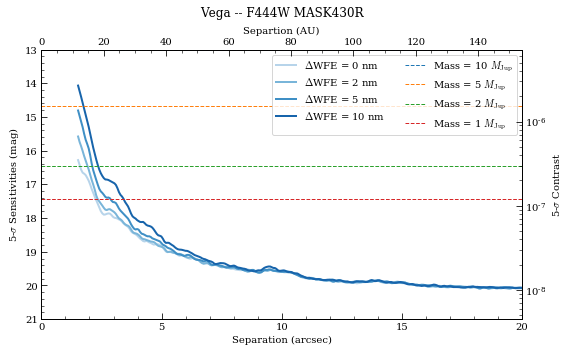

In [63]:
from pynrc.obs_nircam import plot_contrasts, plot_planet_patches

fig, ax = plt.subplots(figsize=(8,5))
xr=[0,20]
yr=[21,13]

# Plot contrast curves and set x/y limits
ax, ax2, ax3 = plot_contrasts(curves, nsig, wfe_list, obs=obs, 
                              xr=xr, yr=yr, ax=ax, return_axes=True)

# Plot Spiegel & Burrows (2012) exoplanet fluxes (Hot Start)
plot_planet_patches(ax, obs, age=age, entropy=13, av_vals=None)
#ax.set_title(ax.get_title(), y=1.1)

ax.legend(ncol=2)

ax.set_title('{} -- {} {}'.format(name_sci, obs.filter, obs.mask), y=1.1)

fig.tight_layout()

fig_name = '{}_{}_{}_contrast.pdf'.format(name_sci, obs.filter, obs.mask)
fig.savefig('Exoplanets/'+fig_name)
#fig.subplots_adjust(top=0.6)

In [ ]:
from astropy.table import Table


# Save curves data
data = []
names =[]

rr = curves[0][0]
data.append(rr)
names.append('Arcsec')

for j, vals in enumerate(curves):
    rr, contrast, sen = vals
    
    data.append(contrast)
    data.append(sen)
    
    wfe = wfe_list[j]
    names.append('Contr_{:.0f}nm'.format(wfe))
    names.append('Sen_{:.0f}nm'.format(wfe))
    
# Modify number formats
tbl = Table(data, names=names)
tbl[names[0]].format = '.4f'
for name in names:
    fmt = tbl[name].format
    if 'Cont' in name:
        fmt = '.3E'
    elif 'Sen' in name:
        fmt ='.4f'
        
    tbl[name].format = fmt

In [ ]:
# Save data
fname = '{}_{}_{}_curves'.format(name_sci, obs.filter, obs.mask)
ascii.write(tbl, 'Exoplanets/'+fname+'.dat')  
ascii.write(tbl, 'Exoplanets/'+fname+'.csv', format='csv')  